# Python数据科学分享——5.推荐系统

> Bandit算法解决EE(Explore VS Exploit)问题，为A/B测试与推荐系统提供新思路

- toc: true 
- badges: true
- comments: true
- categories: [jupyter,Python,Data Science]



<img src="5.data-recs/markmap.png" alt="map" width="700"/>

In [1]:
# %matplotlib widget
from matplotlib.font_manager import _rebuild

_rebuild()
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {"font.sans-serif": ["SimHei", "Arial"]})

import warnings

warnings.filterwarnings("ignore")
import time
import numpy as np
from scipy import stats

import pandas as pd
from sklearn.preprocessing import StandardScaler
from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy

|时间|事件|
|:-:|:-:|
|1891|美国Sittman与Pitt发明老虎机|
|1987|学者提出多臂老虎机问题(multi-armed bandit problem，MAB）|
|1997|使用Thompson采样(1933)解决MAB问题|
|1998|ϵ贪婪算法（epsilon-Greedy Algorithm)|
|2002|UCB算法(Upper Confidence Bound，置信区间上界)|
|2010|Yahoo!提出LinUCB算法|
|2020年2月|美国康奈尔大学与阿里巴巴共同提出了PSLinUCB|

# EE(Explore VS Exploit)问题

[EE，Explore VS Exploit](https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-)：一种运筹学概念，任何profit-seeking系统的基本条件，平衡探索新模型(exploration)与维护旧模型的收益最大化(exploitation)
    1. Explore：A/B实验，惊喜猎奇，新颖多样；强化学习（reinforcement learning）
    1. Exploit：物以类聚、人以群分，尽力迎合用户，使收益最大化（profit maximization）

<img src="5.data-recs/ee.png" alt="map" width="500"/>

# A/B测试


A/B测试分两个阶段进行：
1. Explore阶段：用户分A/B组进行两个模型的对照实验，一段时间内检查两组实验效果
2. Exploit阶段：假设A效果优于B，那么将A组模型覆盖所有用户，放弃B模型

问题：

1. 流量从Explore阶段直接切换到Exploit阶段，缺少平滑过渡，风险较大
2. 在Explore阶段，为了收集足够多的对照数据在B组上浪费资源，在实验时间上没有弹性

# Bandit算法

解决问题：在任意时间任意A/B配置空间做出至今最好的决策，使目标函数收敛
1. 根据实验进展结果，平滑地减少实验数量，避免一刀切
2. 尽可能将资源集中在效果好的实验A上，从而降低资源浪费

概率论的[多臂老虎机问题(multi-armed bandit problem，MAB）](https://en.wikipedia.org/wiki/Multi-armed_bandit)。

假设有3个老虎机在你面前，每台老虎机中奖概率不同，玩哪个老虎机可以做到长期收益最大化？

<img src="5.data-recs/bandit.png" alt="map" width="700"/>

<img src="5.data-recs/bern_bandit.png" alt="map" width="700"/>

1. 摇臂（Arm）：一种选择对应一个摇臂。例如，用户点击哪个房屋？一个房屋是一个Arm
2. 收益（Reward）:选择结果的量化指标。例如，用户点击了3次房屋A，那么得到的收益+3，优于点击2次

In [2]:
class Bandit(object):
    def __init__(self, n, probas=None):
        """
        Parameters:
            n：老虎机arm的数量
            probas：每个老虎机arm中奖概率列表
        """
        self.n = n
        if probas is None:
            np.random.seed(int(time.time()))
            self.probas = np.random.random(self.n)
        else:
            self.probas = probas

        self.best_proba = max(self.probas)

    def generate_reward(self, i):
        """
        选择第i台老虎机，计算收益
        """
        if np.random.random() < self.probas[i]:
            return 1
        else:
            return 0

In [3]:
mab = Bandit(3)

mab.probas

array([0.63347486, 0.14875777, 0.27710719])

In [4]:
# 试验10次（10个时间步）的收益

for n in range(10):
    print([mab.generate_reward(i) for i in range(mab.n)])

[0, 1, 1]
[0, 0, 0]
[1, 0, 0]
[0, 0, 0]
[1, 0, 1]
[0, 0, 1]
[0, 0, 0]
[0, 1, 0]
[1, 1, 1]
[0, 0, 0]


# 累积遗憾（Cumulative regret）

假设每个老虎机每次的收益的服从伯努利分布，取值1或0


$
\begin{aligned}
R_{T} &=\sum_{i=1}^{T}\left(w^{*}-w_{B(i)}\right) \\
&=T w^{*}-\sum_{i=1}^{T} w_{B(i)}
\end{aligned}
$

其中，

T：表示尝试的次数  
$w^{*}$：表示所有老虎机中的最大收益  
$w_{B(i)}$：表示第 i 次试验时被选中老虎机的期望收益  

In [5]:
class Solver(object):
    def __init__(self, bandit):
        """
        Parameters:
            bandit (Bandit): N个老虎机arm
        """
        np.random.seed(int(time.time()))
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.n)
        self.actions = []  # 选择结果列表
        self.regret = 0  # 累积遗憾
        self.regrets = [0]  # 累积遗憾列表

    def update_regret(self, i):
        self.regret += self.bandit.best_proba - self.bandit.probas[i]
        self.regrets.append(self.regret)

    @property
    def estimated_probas(self):
        raise NotImplementedError

    def run_one_step(self):
        """返回当前进行试验老虎机arm索引"""
        raise NotImplementedError

    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()
            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)

# ϵ贪婪算法

ϵ贪婪算法（epsilon-Greedy Algorithm，1998年提出）是一种在当前作出利益最大化的选择（exploit）的贪婪算法，使用ϵ参数调节以实现探索（explore）的效果。概率分布如下：

1. 1 – ϵ：Exploit维持旧模型
2. ϵ / 2：Explore尝试最好或最差实验
3. ϵ=1：均匀探索所有arm，导致资源浪费
3. ϵ=0：停止探索，仅仅维持旧模型

<img src="5.data-recs/epsilon-Greedy.png" alt="map" width="700"/>

In [6]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, eps, init_proba=1):
        """
        Parameters:
            eps (float): 每一步探索的概率
            init_proba (float): 老虎机初始概率，默认为1
        """
        super(EpsilonGreedy, self).__init__(bandit)

        self.eps = eps
        self.estimates = init_proba * np.ones(self.bandit.n)

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        if np.random.random() < self.eps:
            i = np.random.randint(0, self.bandit.n)
        else:
            i = np.argmax(self.estimates)

        r = self.bandit.generate_reward(i)
        self.estimates[i] += 1 / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

In [7]:
def plot_results(solvers, solver_names, figname):
    """
    绘制bandit算法效果图
    Parameters:
        solvers (list<Solver>): 算法实例
        solver_names (list<str)：算法实例显示名称
        figname (str)：
    """
    b = solvers[0].bandit

    fig, ax = plt.subplots(1, 3, figsize=(14, 5))
    fig.subplots_adjust(bottom=0.3, wspace=0.3)

    # 1. 遗憾随时间变化
    for i, s in enumerate(solvers):
        ax[0].plot(range(len(s.regrets)), s.regrets, label=solver_names[i])

    ax[0].set_xlabel("试验次数")
    ax[0].set_ylabel("累计遗憾")
    ax[0].legend(loc=9, bbox_to_anchor=(1.82, -0.25), ncol=5)
    ax[0].grid("k", ls="--", alpha=0.3)

    # 2. 算法参数估计
    sorted_indices = sorted(range(b.n), key=lambda x: b.probas[x])
    ax[1].plot(range(b.n), [b.probas[x] for x in sorted_indices], "k--", markersize=12)
    for s in solvers:
        ax[1].plot(
            range(b.n),
            [s.estimated_probas[x] for x in sorted_indices],
            "x",
            markeredgewidth=2,
        )
    ax[1].set_xlabel("按收益率排序的老虎机")
    ax[1].set_ylabel("估计收益率")
    ax[1].grid("k", ls="--", alpha=0.3)

    # 3.
    for s in solvers:
        ax[2].plot(
            range(b.n), np.array(s.counts) / len(solvers[0].regrets), ls="steps", lw=2,
        )
    ax[2].set_xlabel("老虎机")
    ax[2].set_ylabel("中奖占比")
    ax[2].grid("k", ls="--", alpha=0.3)

    plt.savefig(f'5.data-recs/{figname}')


def experiment(tag, b, K, N, test_solvers, names):
    """
    使用K个带随机收益率的老虎机进行N次试验
    Parameters:
        K (int): 老虎机数量
        N (int): 试验次数
    """

    print(f"老虎机收益率:\n{b.probas}")
    print(f"最佳老虎机: {np.argmax(b.probas)} 收益率: {max(b.probas)}")

    for s in test_solvers:
        s.run(N)

    plot_results(test_solvers, names, f"{tag}_K{K}_N{N}.png")

老虎机收益率:
[0.63347486 0.14875777 0.27710719 0.95064444 0.01736183 0.08938155
 0.95135302 0.85254521 0.68298702 0.50005527]
最佳老虎机: 6 收益率: 0.9513530154669764


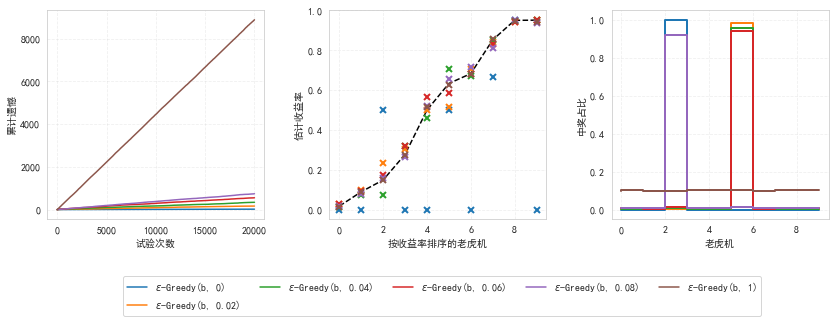

In [8]:
K = 10
b = Bandit(K)
N = 20000
ids = [0, 0.02, 0.04, 0.06, 0.08, 1]
test_solvers = [EpsilonGreedy(b, i) for i in ids]
names = [f"$\epsilon$-Greedy(b, {i})" for i in ids]
experiment("epsilon-Greedy", b, K, N, test_solvers, names)

# [Thompson采样](5.data-recs/1933-thompson.pdf)

Thompson采样（Thompson Sampling）1933提出，1997年学者开始使用它解决MAB问题。

由于Beta分布是伯努利分布的共轭先验分布，因此假设每个老虎机收益服从`Beta(成功次数α, 失败次数β)`先验分布，例如

1. α = 1, β = 1：表示成功率50%，但不是很自信
2. α = 1000, β = 9000：强烈认同成功率10%

迭代步骤：
1. 每次从老虎机的Beta分布抽样，选择随机数最大的老虎机i计算收益，
2. 如果收益=1则，$\alpha_i=\alpha_i+1$，否则收益=0, $\beta_i=\beta_i+1$


缺点：计算后验分布困难，需要借助Gibbs采样、Laplace近似和bootstraps算法计算，[参考教程](5.data-recs/ThompsonSampling.pdf)

In [9]:
class ThompsonSampling(Solver):
    def __init__(self, bandit, init_a=1, init_b=1):
        """
        Parameters:
            init_a (int): Beta(a, b)初始参数a
            init_b (int): Beta(a, b)初始参数b
        """
        super(ThompsonSampling, self).__init__(bandit)

        self._as = init_a * np.ones(self.bandit.n)
        self._bs = init_b * np.ones(self.bandit.n)

    @property
    def estimated_probas(self):
        return self._as / (self._as + self._bs)

    def run_one_step(self):
        i = np.argmax(np.random.beta(self._as, self._bs))
        r = self.bandit.generate_reward(i)

        self._as[i] += r
        self._bs[i] += 1 - r

        return i

随机探索让我们有机会探索未知arm。然而，这种肆意的随机性可能导致我们因为陷入一个收益差的老虎机而终止探索（陷入过拟合）。

因此，一种改进方法是随着时间增加而缩小ϵ，以降低随机性。另一种方式是优先探索不确定性高的老虎机（类似梯度下降法中使用Momentum摆脱局部最优解），

# [UCB](https://towardsdatascience.com/recommender-systems-using-linucb-a-contextual-multi-armed-bandit-approach-35a6f0eb6c4)

UCB(Upper Confidence Bound，置信区间上界，2002年提出）算法持续跟踪每条臂试验累计的平均收益，并计算每条摇臂的UCB。UCB表明了我们对每条摇臂收益估计的不确定性。

如果有一个摇臂的上界非常高，那么说明这个摇臂潜力具有高度不确定性，因此选择手臂，也许说一个更佳的探索机会。

<img src="5.data-recs/ucb.png" alt="map" width="600"/>



虽然摇臂3取得的平均收益更高，但是UCB算法会选择摇臂2，因为它的潜力不确定性UCB更大。

In [10]:
class UCB1(Solver):
    def __init__(self, bandit, init_proba=1):
        super(UCB1, self).__init__(bandit)
        self.t = 0
        self.estimates = init_proba * np.ones(self.bandit.n)

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        self.t += 1
        # 从置信区间上界选择最佳arm
        i = np.argmax(self.estimates + np.sqrt(2 * np.log(self.t) / (1 + self.counts)))
        r = self.bandit.generate_reward(i)
        self.estimates[i] += 1 / (self.counts[i] + 1) * (r - self.estimates[i])
        return i

# 贝叶斯UCB

In [11]:
class BayesianUCB(Solver):
    """假设先验概率服从Beta分布"""
    def __init__(self, bandit, c=3, init_a=1, init_b=1):
        """
        Parameters:
            c (float): 置信区间上界标准差扩展系数
            init_a (int): Beta(a, b)参数a
            init_b (int): Beta(a, b)参数b
        """
        super(BayesianUCB, self).__init__(bandit)
        self.c = c
        self._as = init_a * np.ones(self.bandit.n)
        self._bs = init_b * np.ones(self.bandit.n)
    @property
    def estimated_probas(self):
        return self._as / (self._as + self._bs)
    def run_one_step(self):
        i = np.argmax(
            self._as / (self._as + self._bs)
            + stats.beta.std(self._as, self._bs) * self.c
        )
        r = self.bandit.generate_reward(i)
        # 更新后验分布
        self._as[i] += r
        self._bs[i] += 1 - r
        return i

老虎机收益率:
[0.63347486 0.14875777 0.27710719 0.95064444 0.01736183 0.08938155
 0.95135302 0.85254521 0.68298702 0.50005527]
最佳老虎机: 6 收益率: 0.9513530154669764


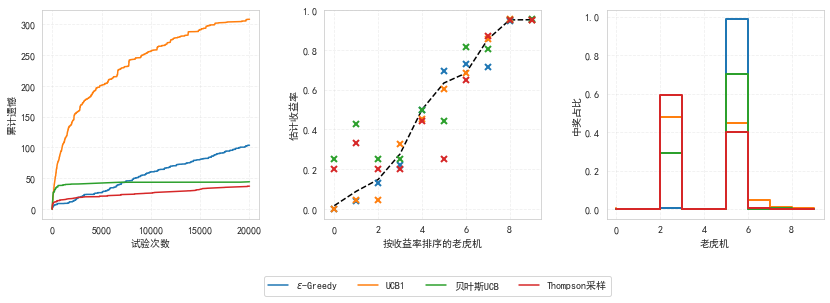

In [12]:
test_solvers = [
    EpsilonGreedy(b, 0.01),
    UCB1(b),
    BayesianUCB(b, 3, 1, 1),
    ThompsonSampling(b, 1, 1),
]
names = [
    r"$\epsilon$-Greedy",
    "UCB1",
    "贝叶斯UCB",
    "Thompson采样",
]
experiment("epsilon-Greedy", b, K, N, test_solvers, names)

然而，由于UCB算法未考虑用户关联特征(上下文)，包括用户的历史行为、人口统计信息等。因此，

1. 2010年，Yahoo!提出[LinUCB](http://rob.schapire.net/papers/www10.pdf)，引入特征向量，对UCB进行改进，提升Yahoo!首页12.5%的点击量。[github代码实现](https://github.com/appurwar/Contextual-Bandit-News-Article-Recommendation)
2. 2020年2月，美国康奈尔大学与阿里巴巴共同提出了[PSLinUCB (Piecewise-Stationary LinUCB, AAAI20)](https://arxiv.org/pdf/2003.00359.pdf)，解决了LinUCB没有考虑用户兴趣会随着时间发生变化的问题。

<img src="5.data-recs/PSLinUSB.png" alt="map" width="1000"/>


# LinUCB示例

[MABWiser](https://fidelity.github.io/)是一个MAB算法快速原型库。它支持上下文无关（context-free）、无参数上下文（non-parametric contextual，例如UCB1）、参数上下文（parametric contextual，例如LinUCB）bandit模型，支持训练和测试并行化、超参数调优、仿真等实用功能。

<img src="5.data-recs/online.png" alt="map" width="700"/>

In [13]:
# Arms
ads = [1, 2, 3, 4, 5]
# 特征
train_df = pd.DataFrame({
        "ad": [1, 1, 1, 2, 4, 5, 3, 3, 2, 1, 4, 5, 3, 2, 5],
        "revenues": [10, 17, 22, 9, 4, 20, 7, 8, 20, 9, 50, 5, 7, 12, 10],
        "age": [22, 27, 39, 48, 21, 20, 19, 37, 52, 26, 18, 42, 55, 57, 38],
        "click_rate": [0.2,0.6,0.99,0.68,0.15,0.23,0.75,0.17,0.33,0.65,0.56,0.22,0.19,0.11,0.83],
        "subscriber": [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
})
train_df.head(7)

,ad,revenues,age,click_rate,subscriber
0,1,10,22,0.20,1
1,1,17,27,0.60,0
2,1,22,39,0.99,1
3,2,9,48,0.68,0
4,4,4,21,0.15,1
5,5,20,20,0.23,0
6,3,7,19,0.75,1


In [14]:
test_df = pd.DataFrame({"age": [37, 52], "click_rate": [0.5, 0.6], "subscriber": [0, 1]})
test_df

,age,click_rate,subscriber
0,37,0.5,0
1,52,0.6,1


In [15]:
# 标准化预处理
scaler = StandardScaler()
train = scaler.fit_transform(train_df[["age", "click_rate", "subscriber"]])
test = scaler.transform(test_df)

In [16]:
# LinUCB模型参数alpha=1.25
linucb = MAB(arms=ads, learning_policy=LearningPolicy.LinUCB(alpha=1.25))

# 基于历史广告点击和效益数据进行训练
linucb.fit(decisions=train_df["ad"], rewards=train_df["revenues"], contexts=train)

# 预测展示的广告
prediction = linucb.predict(test)

print(f"LinUCB预测结果: {prediction}")

LinUCB预测结果: [5, 2]


In [17]:
# 每个arm的期望收益
pd.DataFrame.from_dict(linucb.predict_expectations(test))

,1,2,3,4,5
0,-1.309401,0.105144,-1.912977,-10.291130,9.665161
1,-4.524479,14.652897,4.524684,-3.257354,-8.684806


In [18]:
# 上一轮决策产生的真实收益
test_df_revenue = pd.Series([7, 13])
# 在线更新模型
linucb.partial_fit(decisions=prediction, rewards=test_df_revenue, contexts=test)

# 增加arm
linucb.add_arm(6)

linucb.arms

[1, 2, 3, 4, 5, 6]

参考资料:

1.[multi-armed bandit problem，MAB](https://en.wikipedia.org/wiki/Multi-armed_bandit)  
2.[The Multi-Armed Bandit Problem and Its Solutions](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html#bayesian-ucb)  
3.[Bandit Algorithms for Website Optimization](Bandit_Algorithms_for_Website_Optimization.pdf)  
4.[Bandit 算法与推荐系统](https://cosx.org/2017/05/bandit-and-recommender-systems/)  
5.[Recommender systems using LinUCB: A contextual multi-armed bandit approach](https://towardsdatascience.com/recommender-systems-using-linucb-a-contextual-multi-armed-bandit-approach-35a6f0eb6c4)